In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import math
from tqdm import tqdm
from matplotlib import pyplot as pl
from multiprocessing import Pool
import os
p = Pool(os.cpu_count())

In [2]:
data = np.array([[1.3461, 1.102, 0.911],
[1.6154, 1.208, 0.944],
[1.8846, 1.336, 0.979]]) #rome form factor data, plus = 1, zero = 2

In [3]:
chi0plus = 0.0043
chi1minus = 0.00419

In [4]:
zerosum = (1.86484-0.497611)**2 #D0 and K0

In [5]:
plusminussum = (1.86966-0.493677)**2 #D+- and K+-

In [6]:
0.5*(zerosum+plusminussum)

1.8813221773650004

In [7]:
MD = 0.5*(1.86484+1.86966)
MK = 0.5*(0.497611+0.493677)
(MD-MK)**2 #?????????????? where does their 1.8846 come from?

1.8813030192360003

In [8]:
tminus = 1.8846 #(MD-MK)**2
tplus = (MD+MK)**2
tplus = 5.588947

In [9]:
def z(t):
    return (np.sqrt(tplus-t)-np.sqrt(tplus-tminus))/(np.sqrt(tplus-t)+np.sqrt(tplus-tminus))

In [10]:
def rho(t):
    return np.sqrt((tplus-t)/(tplus-tminus))

In [11]:
ni = 2

In [12]:
def phizero(t):  #outer fn and Blanschke factors
    polevals = [2.3178**2]
    calcz = z(t)
    calcrho = rho(t)
    phizeroval = np.sqrt(2*ni/3)*np.sqrt((3*tplus*tminus)/(4*np.pi))*1/(tplus-tminus)*(1+calcz)*np.power(1-calcz,-5/2)*np.power(rho(0)+(1+calcz)/(1-calcz),-2)*np.power(rho(0)+(1+calcz)/(1-calcz),-2)
    for i in range(len(polevals)):
        phizeroval *= (z(t)-z(polevals[i]))/(1-np.conjugate(z(polevals[i]))*z(t))
    return phizeroval 

In [13]:
def phiplus(t):  #outer fn and Blanschke factors
    polevals = [2.1122**2]
    calcz = z(t)
    calcrho = rho(t)
    phiplusval = np.sqrt(2*ni/3)*np.sqrt(1/(np.pi*(tplus-tminus)))*np.power(1+calcz,2)*np.power(1-calcz,-9/2)*np.power(rho(0)+(1+calcz)/(1-calcz),-2)*np.power(rho(0)+(1+calcz)/(1-calcz),-3)
    for i in range(len(polevals)):
        phiplusval *= (z(t)-z(polevals[i]))/(1-np.conjugate(z(polevals[i]))*z(t))
    return phiplusval

In [14]:
def exclude(G,a,b):
    return np.delete(np.delete(G,b,0),a,1)

In [15]:
#2105.02497 pg 48-50

In [16]:
def alpha(data,charge):
    if charge == 1:
        index = 1
    elif charge == 0:
        index = 2
    alphamat = np.empty([data.shape[0],data.shape[0]])

    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            alphamat[i,j] = 1/(1-z(data[i,0])*z(data[j,0]))
    return np.linalg.det(alphamat)

In [17]:
def G(data,t):
    row = [t]
    row.extend(data[:,0])
    mat = np.empty([data.shape[0]+1,data.shape[0]+1])

    for i in range(len(row)):
        for j in range(len(row)):
            mat[i,j] = 1/(1-z(row[i])*z(row[j]))
    return mat

In [18]:
def beta(data, t, charge):
    if charge == 1:
        index = 1
        phi = phiplus
    elif charge == 0:
        index = 2
        phi = phizero
    ssum = 0
    for j in range(1,data.shape[0]+1):
        ssum += ((-1)**j)*phi(data[j-1,0])*data[j-1,index]*np.linalg.det(exclude(G(data,t),0,j))
    return ssum

In [19]:
def gamma(data, t,charge,chi):
    if charge == 1:
        index = 1
        phi = phiplus
    elif charge == 0:
        index = 2
        phi = phizero
    ssum = chi*np.linalg.det(G(data,t))
    for i in range(1,data.shape[0]+1):
        for j in range(1,data.shape[0]+1):
            ssum -= np.power(-1,j+i)*phi(data[i-1,0])*data[i-1,index]*phi(data[j-1,0])*data[j-1,index]*np.linalg.det(exclude(G(data,t),i,j))
    return ssum

In [20]:
def M11(data,t,charge,chi):
    if charge == 1:
        index = 1
        phi = phiplus
    elif charge == 0:
        index = 2
        phi = phizero
    mat = np.empty([data.shape[0]+1,data.shape[0]+1])
    mat[0,0] = chi
    for i in range(1,data.shape[0]+1):
        mat[i,0] = phi(data[i-1,0])*data[i-1,index]
        mat[0,i] = phi(data[i-1,0])*data[i-1,index]
        for j in range(1,data.shape[0]+1):
            mat[i,j] = G(data,t)[i,j]
    return mat

In [21]:
def formfactor(data, t,charge,chi):
    if charge == 1:
        phi = phiplus
    elif charge == 0:
        phi = phizero
    calcalpha = alpha(data,charge)
    calcbeta = beta(data,t,charge)
    #calcgamma = gamma(data,t,charge,chi)
    #eigenvaluesM11 = np.linalg.eig(M11(data,t,1,chi))[0]
    #eigenvaluesG = np.linalg.eig(G(data,t))[0]
    discrimM11G = np.exp(np.linalg.slogdet(M11(data,t,charge,chi))[1])*np.exp(np.linalg.slogdet(G(data,t))[1])
    #if discrimM11G < 0:
        #print("discriminant is negative: ",discrimM11G)
        #print("M11 eigenvalues are: ",eigenvaluesM11)
#     if np.linalg.det(M11(data,t,charge,chi)) < 0:
#         print("M11 np.linalg.det: ",np.linalg.det(M11(data,t,charge,chi)))
#         print("M11 np.linalg.slogdet: ",np.exp(np.linalg.slogdet(M11(data,t,charge,chi))))
#     if np.linalg.det(G(data,t)) < 0:
#         print("G np.linalg.det: ",np.linalg.det(G(data,t)))
#         print("G np.linalg.slogdet: ",np.exp(np.linalg.slogdet(G(data,t))))
        #print("G eigenvalues are: ",eigenvaluesG)
    lowerbound = (-calcbeta-np.sqrt(discrimM11G))/(calcalpha*phi(t))
    upperbound = (-calcbeta+np.sqrt(discrimM11G))/(calcalpha*phi(t))
    return [lowerbound,upperbound]

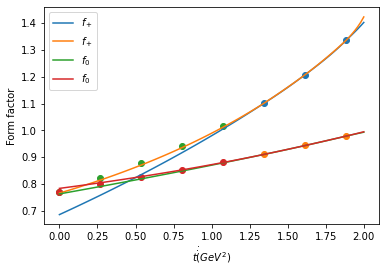

In [22]:
x = np.linspace(0,2,101)
plt.plot(x,[formfactor(data,i,1,chi1minus) for i in x],label = r"$f_+$")
plt.plot(x,[formfactor(data,i,0,chi0plus) for i in x],label = r"$f_0$")
plt.scatter(data[:,0],data[:,1])
plt.scatter(data[:,0],data[:,2])

romevals = np.array([[0.0, 0.765, 0.765, 0.772, 0.772],
[0.2692, 0.815, 0.792, 0.822, 0.800],
[0.5385, 0.872, 0.820, 0.878, 0.826],
[0.8077, 0.937, 0.849, 0.942, 0.853],
[1.0769, 1.013, 0.879, 1.015, 0.882]])
plt.scatter(romevals[:,0],romevals[:,3])
plt.scatter(romevals[:,0],romevals[:,4])
plt.xlabel(r"$t \.\.(GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.show()

In [23]:
formfactor(data,0,1,chi1minus)

[0.6865832012287775, 0.7666559216249356]

In [24]:
formfactor(data,0,0,chi0plus)

[0.7636256554735309, 0.784224280669047]

In [25]:
[alpha(data,0),alpha(data,1)]

[9.520780805915746e-11, 9.520780805915746e-11]

In [26]:
[phizero(1.3461),phiplus(1.3461)]

[0.0012959736610956253, 0.0003276657539487115]

In [27]:
[phizero(1.6154),phiplus(1.6154)]

[0.0009722779455503736, 0.00021295225661040245]

In [28]:
[phizero(1.8846),phiplus(1.8846)]

[0.0006231402362417485, 9.766030302583066e-05]

In [29]:
##### Uncertainty #######

In [30]:
# Normal distribution sampling
SDarray = np.array([
[0.038, 0.019],
[0.044, 0.019],
[0.054, 0.019]])

In [31]:
covmatrix = np.array([[0.00095048337, 0.00086115559, 0.00076822929, 0.00067139737, 0.00057032189, 0.00046461266, 0.00035382373, 0.00023743786, 0.00093372326, 0.00091131333, 0.00088169768, 0.00084279034, 0.00079172189, 0.00072447152, 0.00063523124],  
[0.00086115559, 0.00078515556, 0.00070607957, 0.00062368504, 0.00053767967, 0.00044773144, 0.00035346098, 0.00025442805, 0.00085206316, 0.00083894582, 0.00082066442, 0.00079568390, 0.00076188560, 0.00071629634, 0.00065461116],  
[0.00076822929, 0.00070607957, 0.00064142818, 0.00057404882, 0.00050372187, 0.00043017086, 0.00035308565, 0.00027210610, 0.00076710907, 0.00076365966, 0.00075717032, 0.00074667912, 0.00073084851, 0.00070779522, 0.00067477803],  
[0.00067139737, 0.00062368504, 0.00057404882, 0.00052233064, 0.00046833577, 0.00041187082, 0.00035269283, 0.00029052511, 0.00067858404, 0.00068520846, 0.00069100626, 0.00069561272, 0.00069850419, 0.00069893308, 0.00069578757],  
[0.00057032189, 0.00053767967, 0.00050372187, 0.00046833577, 0.00043140396, 0.00039276887, 0.00035228288, 0.00030975141, 0.00058617957, 0.00060331939, 0.00062194289, 0.00064230877, 0.00066474294, 0.00068968328, 0.00071771878],  
[0.00046461266, 0.00044773144, 0.00043017086, 0.00041187082, 0.00039276887, 0.00037279630, 0.00035185424, 0.00032985927, 0.00048953884, 0.00051767609, 0.00054971326, 0.00058656101, 0.00062943376, 0.00068000920, 0.00074065513],  
[0.00035382373, 0.00035346098, 0.00035308565, 0.00035269283, 0.00035228288, 0.00035185424, 0.00035141065, 0.00035093414, 0.00038825440, 0.00042791779, 0.00047401349, 0.00052813546, 0.00059242935, 0.00066987229, 0.00076469633],  
[0.00023743786, 0.00025442805, 0.00027210610, 0.00029052511, 0.00030975141, 0.00032985927, 0.00035093414, 0.00037307838, 0.00028185308, 0.00033362480, 0.00039448913, 0.00046675785, 0.00055355489, 0.00065922240, 0.00078995092],  
[0.00093372326, 0.00085206316, 0.00076710907, 0.00067858404, 0.00058617957, 0.00048953884, 0.00038825440, 0.00028185308, 0.00093183118, 0.00092700129, 0.00091836176, 0.00090470689, 0.00088436880, 0.00085499959, 0.00081318331],  
[0.00091131333, 0.00083894582, 0.00076365966, 0.00068520846, 0.00060331939, 0.00051767609, 0.00042791779, 0.00033362480, 0.00092700129, 0.00094300108, 0.00095919909, 0.00097546032, 0.00099153820, 0.00100707070, 0.00102148152],  
[0.00088169768, 0.00082066442, 0.00075717032, 0.00069100626, 0.00062194289, 0.00054971326, 0.00047401349, 0.00039448913, 0.00091836176, 0.00095919909, 0.00100505872, 0.00105703236, 0.00111659949, 0.00118576848, 0.00126735992],  
[0.00084279034, 0.00079568390, 0.00074667912, 0.00069561272, 0.00064230877, 0.00058656101, 0.00052813546, 0.00046675785, 0.00090470689, 0.00097546032, 0.00105703236, 0.00115205144, 0.00126402614, 0.00139785199, 0.00156044486],  
[0.00079172189, 0.00076188560, 0.00073084851, 0.00069850419, 0.00066474294, 0.00062943376, 0.00059242935, 0.00055355489, 0.00088436880, 0.00099153820, 0.00111659949, 0.00126402614, 0.00143985862, 0.00165246003, 0.00191376844],  
[0.00072447152, 0.00071629634, 0.00070779522, 0.00069893308, 0.00068968328, 0.00068000920, 0.00066987229, 0.00065922240, 0.00085499959, 0.00100707070, 0.00118576848, 0.00139785199, 0.00165246003, 0.00196229709, 0.00234545168],  
[0.00063523124, 0.00065461116, 0.00067477803, 0.00069578757, 0.00071771878, 0.00074065513, 0.00076469633, 0.00078995092, 0.00081318331, 0.00102148152, 0.00126735992, 0.00156044486, 0.00191376844, 0.00234545168, 0.00288135740]])

In [32]:
def resample(data):
    resample = data.copy()
    for i in range(1,data.shape[1]):
        for j in range(data.shape[0]):
            resample[j,i] = np.random.normal(data[j,i],SDarray[j,i-1])
    return resample

In [33]:
excludelist = [0,1,2,3,4,8,9,10,11]

trimmedcov = np.delete(covmatrix,excludelist,axis=0)
trimmedcov = np.delete(trimmedcov,excludelist,axis=1)
trimmedcov

array([[0.0003728 , 0.00035185, 0.00032986, 0.00062943, 0.00068001,
        0.00074066],
       [0.00035185, 0.00035141, 0.00035093, 0.00059243, 0.00066987,
        0.0007647 ],
       [0.00032986, 0.00035093, 0.00037308, 0.00055355, 0.00065922,
        0.00078995],
       [0.00062943, 0.00059243, 0.00055355, 0.00143986, 0.00165246,
        0.00191377],
       [0.00068001, 0.00066987, 0.00065922, 0.00165246, 0.0019623 ,
        0.00234545],
       [0.00074066, 0.0007647 , 0.00078995, 0.00191377, 0.00234545,
        0.00288136]])

In [34]:
np.sqrt(np.diagonal(trimmedcov))

array([0.01930793, 0.01874595, 0.01931524, 0.03794547, 0.04429782,
       0.05367828])

In [35]:
def covresample(data):
    vectordata = np.hstack([data[:,2],data[:,1]])
    excludelist = [0,1,2,3,4,8,9,10,11]
    trimmedcov = np.delete(covmatrix,excludelist,axis=0)
    trimmedcov = np.delete(trimmedcov,excludelist,axis=1)
    resampledvectordata = np.random.multivariate_normal(vectordata,trimmedcov)
    resampleddata = np.array([data[:,0],resampledvectordata[3:6],resampledvectordata[0:3]])
    return np.transpose(resampleddata)

In [36]:
def dispmethod(chg,tchosen,Nboot):
    N0 = 5
    fbaruplist = []
    fbarlolist = []
    nancount = 0
    unifailcount = 0
    for y in range(Nboot):
        newdata = covresample(data)
        if chg == 1:
            chi = np.random.normal(chi1minus,0.00036)
        if chg == 0:
            chi = np.random.normal(chi0plus,0.0013)
        
        plusbounds = formfactor(newdata,0,1,chi)
        zerobounds = formfactor(newdata,0,0,chi)
        upper = min(plusbounds[1],zerobounds[1])
        lower = max(plusbounds[0],zerobounds[0])
        if upper <= lower:
            continue
        if np.linalg.det(M11(newdata,tchosen,1,chi)) < 0 or np.linalg.det(M11(newdata,tchosen,0,chi))< 0:
            #print("unitarity check failed")
            unifailcount += 1
            continue
#         if np.linalg.det(M11(newdata,tchosen,0,chi)) < 0:
#             unifailcount += 1
#             continue
        fbarup = 0
        fbarlo = np.Inf
        rangeN0 = np.linspace(lower,upper,N0)
        for k in rangeN0:
            originval = k#np.random.uniform(lower,upper)
            extendednewdata = np.vstack([newdata,[0,originval,originval]])
            tchosenbounds = formfactor(extendednewdata,tchosen,chg,chi)
            fbarup = max(tchosenbounds[1],fbarup)
            fbarlo = min(tchosenbounds[0],fbarlo)
            
        
        if np.isnan(fbarup):
            nancount+=1
        if nancount > 10:
            print("NaN values skipped for t=",tchosen)
            break
        fbaruplist.append(fbarup)
        fbarlolist.append(fbarlo)
    print("for t = ",tchosen," unitarity fail percentage is ",(unifailcount*100)/Nboot,"%")
    print("for t = ",tchosen," other fail percentage is ",((Nboot-len(fbarlolist)-unifailcount)*100)/Nboot,"%")
    return [fbarlolist,fbaruplist]

In [37]:
##investigating why calcbeta**2 + calcalpha*calcgamma is negative for some t's

def sqrtcheck(data, t,charge):
    if charge == 1:
        phi = phiplus
    elif charge == 0:
        phi = phizero
    calcalpha = alpha(data,charge)
    calcbeta = beta(data,t,charge)
    calcgamma = gamma(data,t,charge)
    output = calcbeta**2 + calcalpha*calcgamma
    return output

In [38]:
tchosenlist = [0.0, 0.2692, 0.5385, 0.8077, 1.0769, 1.3461, 1.6154, 1.8846] #np.linspace(0,1.8,31)#[0.01,0.2692,0.5384,0.8077,1.0769,1.4,1.65,1.8]#[1.26]#

In [39]:
Nboot = 100

In [40]:
def mult_dispmethod1(tchosen):
    return dispmethod(1,tchosen,100)

In [ ]:
multoutput = p.map(mult_dispmethod1, tchosenlist)

In [ ]:
multoutput

In [6]:
dispresultsplus = np.empty([len(tchosenlist),4])
histplus = np.zeros([len(tchosenlist),3], dtype=np.object)
counter = 0
for tchosen in tchosenlist:
    result = np.array(dispmethod(1,tchosen,Nboot))
    dispresultsplus[counter,0] = tchosen
    averageffplus = 0.5*(np.nanmean(result[0])+np.nanmean(result[1]))
    deltaplus = result-np.nanmean(result)
    varpluslo = np.sum(deltaplus[0]**2)/(len(result[0])-1)
    varplusup = np.sum(deltaplus[1]**2)/(len(result[0])-1)
    rhoplus = np.sum(deltaplus[0]*deltaplus[1])/(len(result[0])-1)
    varplus = ((np.nanmean(result[0])-np.nanmean(result[1]))**2)/12 + (varpluslo+varplusup+rhoplus*np.sqrt(varpluslo)*np.sqrt(varplusup))/3
    dispresultsplus[counter,1] = averageffplus
    dispresultsplus[counter,2] = averageffplus-np.sqrt(varplus)
    dispresultsplus[counter,3] = averageffplus+np.sqrt(varplus)
    histplus[counter,0] = tchosen
    histplus[counter,1] = result[0]
    histplus[counter,2] = result[1]
    counter += 1

NameError: name 'np' is not defined

In [91]:
dispresultszero = np.empty([len(tchosenlist),4])
histzero = np.zeros([len(tchosenlist),3], dtype=np.object)
counter = 0
for tchosen in tchosenlist:
    result = np.array(dispmethod(0,tchosen,Nboot))
    dispresultszero[counter,0] = tchosen
    averageffzero = 0.5*(np.nanmean(result[0])+np.nanmean(result[1]))
    deltazero = result-np.nanmean(result)
    varzerolo = np.sum(deltazero[0]**2)/(len(result[0])-1)
    varzeroup = np.sum(deltazero[1]**2)/(len(result[0])-1)
    rhozero = np.sum(deltazero[0]*deltazero[1])/(len(result[0])-1)
    varzero = (np.nanmean(result[0])-np.nanmean(result[1]))**2/12 + (varzerolo+varzeroup+rhozero*np.sqrt(varzerolo)*np.sqrt(varzeroup))/3
    dispresultszero[counter,1] = averageffzero
    dispresultszero[counter,2] = averageffzero-np.sqrt(varzero)
    dispresultszero[counter,3] = averageffzero+np.sqrt(varzero)                                           
    histzero[counter,0] = tchosen
    histzero[counter,1] = result[0]
    histzero[counter,2] = result[1]
    counter += 1

  1%|          | 11/1000 [00:00<00:22, 43.93it/s]

for t =  0.0  unitarity fail percentage is  0.0 %
for t =  0.0  other fail percentage is  40.8 %


  1%|          | 7/1000 [00:00<00:17, 57.99it/s]

for t =  0.2692  unitarity fail percentage is  0.0 %
for t =  0.2692  other fail percentage is  41.5 %


  0%|          | 4/1000 [00:00<00:36, 27.46it/s]

for t =  0.5385  unitarity fail percentage is  0.0 %
for t =  0.5385  other fail percentage is  40.2 %


  1%|          | 7/1000 [00:00<00:32, 30.99it/s]

for t =  0.8077  unitarity fail percentage is  0.0 %
for t =  0.8077  other fail percentage is  41.8 %


  1%|          | 8/1000 [00:00<00:26, 37.58it/s]

for t =  1.0769  unitarity fail percentage is  0.0 %
for t =  1.0769  other fail percentage is  42.1 %


  0%|          | 3/1000 [00:00<00:33, 29.77it/s]

for t =  1.3461  unitarity fail percentage is  0.0 %
for t =  1.3461  other fail percentage is  40.2 %


  1%|          | 7/1000 [00:00<00:31, 31.81it/s]

for t =  1.6154  unitarity fail percentage is  0.0 %
for t =  1.6154  other fail percentage is  40.8 %


100%|██████████| 1000/1000 [00:30<00:00, 32.33it/s]

for t =  1.8846  unitarity fail percentage is  0.0 %
for t =  1.8846  other fail percentage is  39.6 %


In [92]:
np.mean(histzero[0,1])

0.7670323256187542

In [93]:
np.mean(histzero[0,2])

0.7792120417613563

In [94]:
dispresultszero

array([[0.        , 0.77312218, 0.74684501, 0.79939936],
       [0.2692    , 0.797793  , 0.77480334, 0.82078266],
       [0.5385    , 0.82598331, 0.80514219, 0.84682444],
       [0.8077    , 0.85237362, 0.83453198, 0.87021527],
       [1.0769    , 0.88131621, 0.86388271, 0.89874971],
       [1.3461    , 0.90815253, 0.89158226, 0.92472281],
       [1.6154    , 0.94303796, 0.92885976, 0.95721616],
       [1.8846    , 0.97650814, 0.96108403, 0.99193226]])

In [95]:
dispresultsplus

array([[0.        , 0.7743752 , 0.74983635, 0.79891404],
       [0.2692    , 0.82391843, 0.7997015 , 0.84813536],
       [0.5385    , 0.87346066, 0.84946349, 0.89745784],
       [0.8077    , 0.93682279, 0.90930028, 0.96434529],
       [1.0769    , 1.01090747, 0.98271003, 1.03910491],
       [1.3461    , 1.09578312, 1.06675024, 1.12481599],
       [1.6154    , 1.1931907 , 1.15869577, 1.22768564],
       [1.8846    , 1.31797177, 1.27898648, 1.35695705]])

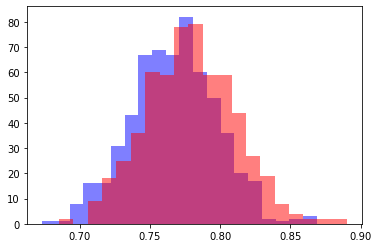

In [96]:
plt.hist(histzero[0,1],bins=20,color="blue", alpha=0.5)
plt.hist(histzero[0,2],bins=20,color="red", alpha=0.5)
plt.show()

In [97]:
len(histplus[0,2])

600

In [98]:
errortable = np.zeros([len(tchosenlist),5])
counter = 0
for t in tchosenlist:
    errortable[counter,0] = t
    errortable[counter,3] = round(dispresultszero[counter,1],3)
    errortable[counter,4] = round(dispresultszero[counter,1] - dispresultszero[counter,2],3)
    errortable[counter,1] = round(dispresultsplus[counter,1],3)
    errortable[counter,2] = round(dispresultsplus[counter,1] - dispresultsplus[counter,2],3)
    counter += 1

errortable

array([[0.    , 0.774 , 0.025 , 0.773 , 0.026 ],
       [0.2692, 0.824 , 0.024 , 0.798 , 0.023 ],
       [0.5385, 0.873 , 0.024 , 0.826 , 0.021 ],
       [0.8077, 0.937 , 0.028 , 0.852 , 0.018 ],
       [1.0769, 1.011 , 0.028 , 0.881 , 0.017 ],
       [1.3461, 1.096 , 0.029 , 0.908 , 0.017 ],
       [1.6154, 1.193 , 0.034 , 0.943 , 0.014 ],
       [1.8846, 1.318 , 0.039 , 0.977 , 0.015 ]])

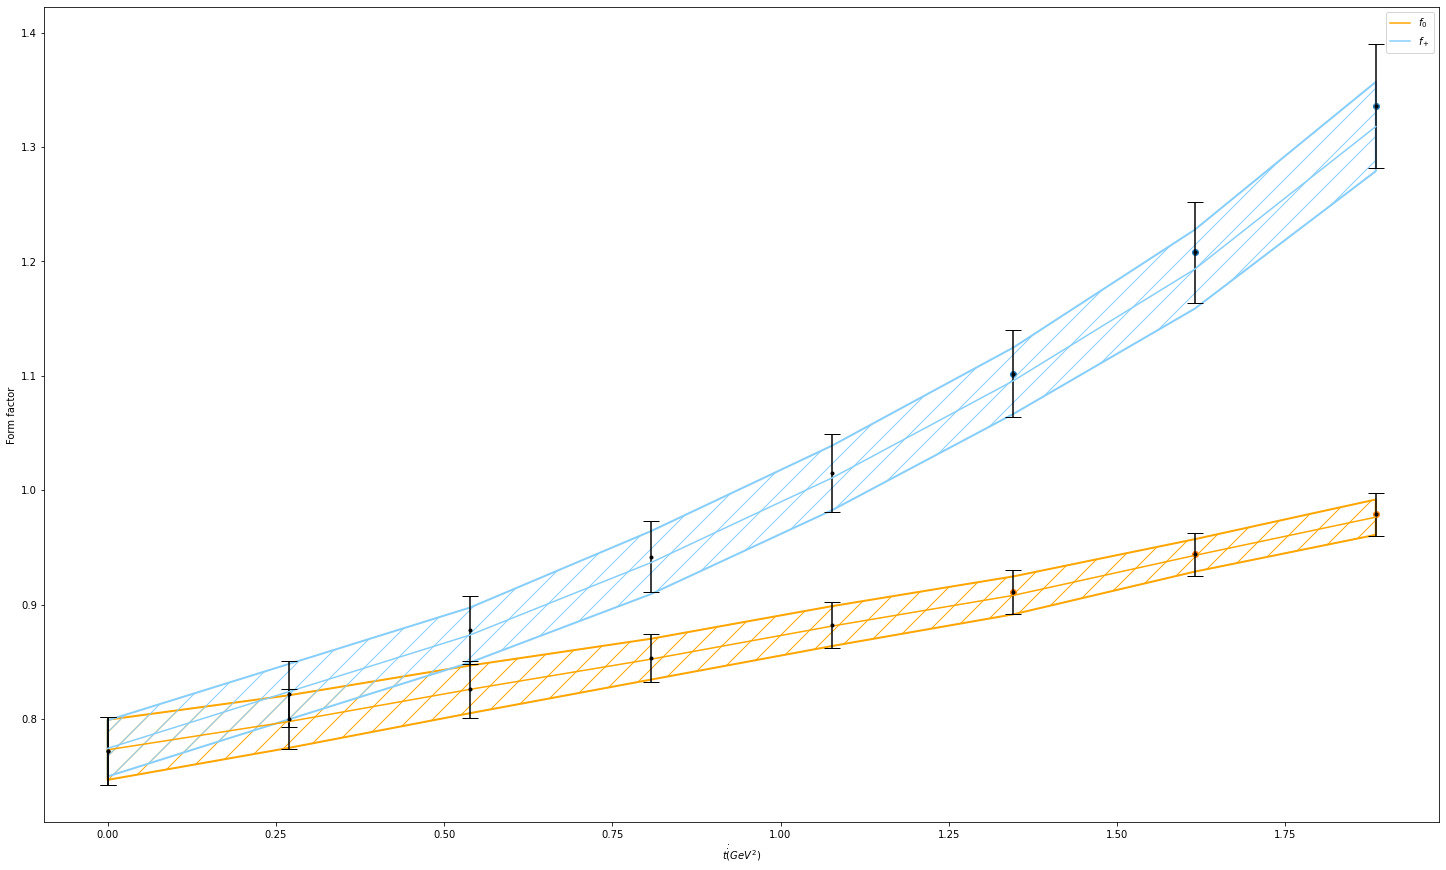

In [100]:
#x = np.linspace(0,2,101)
plt.scatter(data[:,0],data[:,1])
plt.scatter(data[:,0],data[:,2])
plt.plot(dispresultszero[:,0],dispresultszero[:,1],label = r"$f_0$",color="orange")
pl.fill_between(dispresultszero[:,0],dispresultszero[:,2],dispresultszero[:,3],linewidth=2,hatch='/',edgecolor="orange",facecolor="none")
plt.plot(dispresultsplus[:,0],dispresultsplus[:,1],label = r"$f_+$",color="lightskyblue")
pl.fill_between(dispresultsplus[:,0],dispresultsplus[:,2],dispresultsplus[:,3],linewidth=2,hatch='/',edgecolor="lightskyblue",facecolor="none")
romevals = np.array([[0.0, 0.765, 0.765, 0.772, 0.772],
[0.2692, 0.815, 0.792, 0.822, 0.800],
[0.5385, 0.872, 0.820, 0.878, 0.826],
[0.8077, 0.937, 0.849, 0.942, 0.853],
[1.0769, 1.013, 0.879, 1.015, 0.882],
[1.3461, 1.102, 0.911, 1.102, 0.911],
[1.6154, 1.208, 0.944, 1.208, 0.944],
[1.8846, 1.336, 0.979, 1.336, 0.979]])
romeerrorvals = np.array([
[0.031, 0.031, 0.030, 0.030],
[0.031, 0.028, 0.029, 0.026],
[0.031, 0.025, 0.030, 0.025],
[0.032, 0.023, 0.031, 0.021],
[0.034, 0.021, 0.034, 0.020],
[0.038, 0.019, 0.038, 0.019],
[0.044, 0.019, 0.044, 0.019],
[0.054, 0.019, 0.054, 0.019]])

#plt.scatter(romevals[:,0],romevals[:,3])
pl.errorbar(romevals[:,0], romevals[:,3], romeerrorvals[:,2], fmt='.k',capsize=8)
#plt.scatter(romevals[:,0],romevals[:,4])
pl.errorbar(romevals[:,0], romevals[:,4], romeerrorvals[:,3], fmt='.k',capsize=8)

#plt.xlim(0,1.1)
#plt.ylim(0.75,1.1)
plt.xlabel(r"$t \.\. (GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.rcParams["figure.figsize"] = (25,15)
plt.show()

In [ ]:
#x = np.linspace(0,2,101)
#plt.scatter(data[:,0],data[:,1])
#plt.scatter(data[:,0],data[:,2])
#plt.plot(dispresultszero[:,0],dispresultszero[:,1],label = r"$f_0$")
#plt.plot(dispresultszero[:,0],dispresultszero[:,2],label = r"$f_0$ Lower bound")
#plt.plot(dispresultszero[:,0],dispresultszero[:,3],label = r"$f_0$ Upper bound")
plt.plot(plusnonan[:,0],plusnonan[:,1],label = r"$f_+$")
plt.plot(plusnonan[:,0],plusnonan[:,2],label = r"$f_+$ Lower bound")
plt.plot(plusnonan[:,0],plusnonan[:,3],label = r"$f_+$ Upper bound")
romevals = np.array([[0.0, 0.765, 0.765, 0.772, 0.772],
[0.2692, 0.815, 0.792, 0.822, 0.800],
[0.5385, 0.872, 0.820, 0.878, 0.826],
[0.8077, 0.937, 0.849, 0.942, 0.853],
[1.0769, 1.013, 0.879, 1.015, 0.882]])
plt.scatter(romevals[:,0],romevals[:,3])
plt.scatter(romevals[:,0],romevals[:,4])
#plt.xlim(0,1.1)
#plt.ylim(0.75,1.1)
plt.xlabel(r"$t \.\. (GeV^2)$")
plt.ylabel("Form factor")
plt.legend()
plt.rcParams["figure.figsize"] = (15,15)
plt.show()